In [1]:
# Load packages for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load packages for Big Query 
from google.cloud import bigquery
import os

### Set-up

**Set-up: GCP interface** 

Run before querying to setup Big Query

In [2]:
# Define configurations for Big Query - Stride Datalake
project_id = 'som-nero-phi-boussard' # Location of stride datalake
db = "som-nero-phi-boussard.stride_datalake" # Define the database
msc = "som-nero-phi-boussard.MSc_ACU_Oncology"
es = "som-nero-phi-boussard.ES_ACU_Oncology"
client = bigquery.Client(project=project_id) # Set project to project_id
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/path/to/your/credentials.json'
os.environ['GCLOUD_PROJECT'] = "som-nero-phi-boussard" # specify environment
db = "som-nero-phi-boussard" # Define the database

/Users/eliasaquand/miniforge3/envs/env/lib/python3.9/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


**Set-up: GCP data table creation in Big Query**

In [3]:
# 1) Specify the job config to properly read the file
job_config = bigquery.LoadJobConfig()
job_config.autodetect = True # determines the datatype of the variable
job_config.write_disposition = 'WRITE_TRUNCATE'
job_config.max_bad_records = 1 # allow 5 bad records; 

# Read schema from JSON
# job_config.schema = self.bq_client.schema_from_json(
# f"{json_schema_dir}/{custom_mapping_table}.json")

# 2) Specify destination
# destination = f"som-nero-phi-boussard.MSc_ACU_Oncology.[COHORT NAME]"

# 3) Save file ob Big Query, using result from so far; client is specified above - implemented in the file 
# load_job = client.load_table_from_dataframe(dataframe = chemo_tx_dd,                                  
#                                                     destination = destination,
#                                                     job_config = job_config)

# Run the job:
# load_job.result()

### Load cohort

In [4]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_text"""
cohort = (client.query(sql_query)).to_dataframe()

In [5]:
cohort

,PAT_DEID,HOSP_ADMSN_TIME,CHE_TX_DATE
0,1770802,2020-02-07 20:54:00,2020-01-16 00:00:00
1,3945576,2020-02-01 09:14:00,2020-01-24 00:00:00
2,1045640,2016-02-15 20:12:00,2016-02-08 00:00:00
3,1289918,2016-04-15 23:13:00,2016-03-16 00:00:00
4,2766580,2016-04-13 17:43:00,2016-03-24 00:00:00
...,...,...,...
1748,538184,2015-02-13 13:13:00,2015-01-16 08:59:00
1749,1253627,2019-03-14 16:38:00,2019-03-08 23:59:00
1750,3456627,2018-11-12 13:20:00,2018-10-17 09:59:00
1751,3316652,2014-06-06 19:31:00,2014-06-05 23:59:00


### Load updated symptom df

In [6]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_sym_op30"""
cohort_p1_sym_op30 = (client.query(sql_query)).to_dataframe()

### Count the number of symptoms per patients

In [7]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_sym_op30"""
cohort_p1_sym = (client.query(sql_query)).to_dataframe()

In [8]:
# Count the occurence of each symptom for each patient
cohort_p1_sym.groupby(['PAT_DEID', 'DX_SHORT'])['PAT_DEID'].value_counts()

PAT_DEID  DX_SHORT  PAT_DEID
31        ANEMIA    31          1
2374      DIARRHEA  2374        1
          EMESIS    2374        1
          FEVER     2374        2
          PAIN      2374        1
                               ..
4259783   PAIN      4259783     5
4316371   ANEMIA    4316371     1
          PAIN      4316371     2
4317533   ANEMIA    4317533     2
          PAIN      4317533     3
Name: PAT_DEID, Length: 4348, dtype: int64

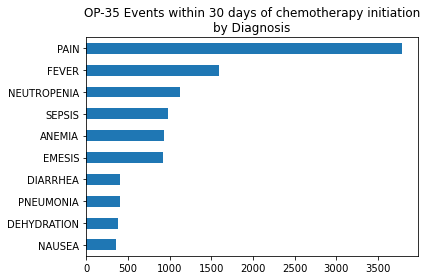

In [9]:
fig,ax = plt.subplots()
(cohort_p1_sym.DX_SHORT.value_counts()[::-1]).plot(kind="barh",title="OP-35 Events within 30 days of chemotherapy initiation\nby Diagnosis",ax=ax)
plt.tight_layout()

In [10]:
cohort_p1_sym[["PT_CLASS", "PRIMARY"]].value_counts()

PT_CLASS            PRIMARY
Inpatient           N          3071
                    Y          1468
Emergency Services  N           692
                    Y           682
dtype: int64

In [11]:
cohort_p1_sym[cohort_p1_sym['PT_CLASS'] == 'Inpatient']['ICD10'].isna().sum()

342

In [12]:
cohort_p1_sym[cohort_p1_sym['PT_CLASS'] == 'Emergency Services']['ICD10'].isna().sum()

10

In [13]:
cohort_p1_sym.PRIMARY.value_counts()

N    3763
Y    2150
Name: PRIMARY, dtype: int64

In [14]:
cohort_p1_sym.ICD10.value_counts(normalize=True)[:10]

R50.9     0.096105
G89.3     0.082741
R11.2     0.059236
R50.81    0.053170
D70.9     0.048431
A41.9     0.047010
R10.9     0.042555
D63.0     0.041987
R19.7     0.038385
R11.0     0.035826
Name: ICD10, dtype: float64

In [15]:
cohort_p1_sym[cohort_p1_sym['PT_CLASS'] == 'Emergency Services']['ICD10'].value_counts(normalize=True)[:10]

R50.9     0.167356
R11.2     0.082759
R10.9     0.080920
R07.9     0.069885
R19.7     0.048736
R11.0     0.043218
R51       0.038161
R07.89    0.036322
R10.13    0.033563
E86.0     0.033563
Name: ICD10, dtype: float64

In [16]:
cohort_p1_sym[cohort_p1_sym['PT_CLASS'] == 'Inpatient']['ICD10'].value_counts(normalize=True)[:10]

G89.3     0.100764
R50.9     0.077603
R50.81    0.061485
A41.9     0.058381
D70.9     0.056471
R11.2     0.053128
D63.0     0.052770
J18.9     0.036652
R19.7     0.035697
R11.0     0.033906
Name: ICD10, dtype: float64

In [17]:
cohort_p1_sym.ICD9.value_counts()[:10]

780.60    523
338.3     293
787.01    277
787.91    217
780.61    212
276.51    187
486       184
789.00    181
285.9     180
288.00    177
Name: ICD9, dtype: int64

In [18]:
# Keep only one occurance of each symptom for each patient 
cohort_p1_sym_unique = cohort_p1_sym.drop_duplicates(['PAT_DEID', 'DX_SHORT'])

In [19]:
cohort_p1_sym_unique.groupby(['PAT_DEID', 'DX_SHORT'])['PAT_DEID'].value_counts()

PAT_DEID  DX_SHORT  PAT_DEID
31        ANEMIA    31          1
2374      DIARRHEA  2374        1
          EMESIS    2374        1
          FEVER     2374        1
          PAIN      2374        1
                               ..
4259783   PAIN      4259783     1
4316371   ANEMIA    4316371     1
          PAIN      4316371     1
4317533   ANEMIA    4317533     1
          PAIN      4317533     1
Name: PAT_DEID, Length: 4348, dtype: int64

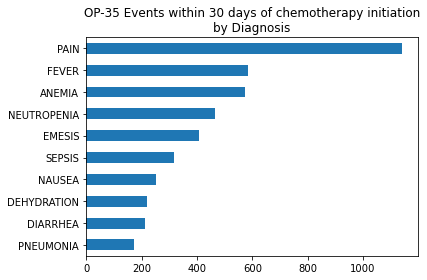

In [20]:
fig,ax = plt.subplots()
(cohort_p1_sym_unique.DX_SHORT.value_counts()[::-1]).plot(kind="barh",title="OP-35 Events within 30 days of chemotherapy initiation\nby Diagnosis",ax=ax)
plt.tight_layout()

In [21]:
cohort_p1_sym_unique.DX_SHORT.value_counts()

PAIN           1140
FEVER           583
ANEMIA          574
NEUTROPENIA     466
EMESIS          409
SEPSIS          318
NAUSEA          252
DEHYDRATION     220
DIARRHEA        212
PNEUMONIA       174
Name: DX_SHORT, dtype: int64

In [22]:
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_sym_unique"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_sym_unique,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=94775efc-c1e7-42c5-bbbc-547cfd2cf5b3>

### Count the number of patients per classes

In [23]:
class_1 = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["PAIN"]))
class_2 = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["NAUSEA","EMESIS", "DEHYDRATION", "DIARRHEA"]))
class_3 = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["ANEMIA"]))
class_4 = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["FEVER", "NEUTROPENIA", "SEPSIS", "PNEUMONIA"]))

# Define adverse event classes and ae_class
cohort_p1_sym_unique['AE_CLASS'] = np.nan
cohort_p1_sym_unique.loc[class_1,'AE_CLASS'] = "CLASS_1"
cohort_p1_sym_unique.loc[class_2,'AE_CLASS'] = "CLASS_2"
cohort_p1_sym_unique.loc[class_3,'AE_CLASS'] = "CLASS_3"
cohort_p1_sym_unique.loc[class_4,'AE_CLASS'] = "CLASS_4"

<ipython-input-23-00bddeb58246>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_p1_sym_unique['AE_CLASS'] = np.nan


In [24]:
class_1 

0         True
1        False
2         True
4        False
5        False
         ...  
10887     True
10894    False
10895     True
10899     True
10902     True
Name: DX_SHORT, Length: 4348, dtype: bool

In [25]:
# Keep only one occurance of each class for each patient 
cohort_p1_class = cohort_p1_sym_unique.drop_duplicates(['PAT_DEID', 'AE_CLASS'])

In [26]:
cohort_p1_class.groupby(['PAT_DEID', 'AE_CLASS'])['PAT_DEID'].value_counts()

PAT_DEID  AE_CLASS  PAT_DEID
31        CLASS_3   31          1
2374      CLASS_1   2374        1
          CLASS_2   2374        1
          CLASS_4   2374        1
4067      CLASS_1   4067        1
                               ..
4259783   CLASS_3   4259783     1
4316371   CLASS_1   4316371     1
          CLASS_3   4316371     1
4317533   CLASS_1   4317533     1
          CLASS_3   4317533     1
Name: PAT_DEID, Length: 3371, dtype: int64

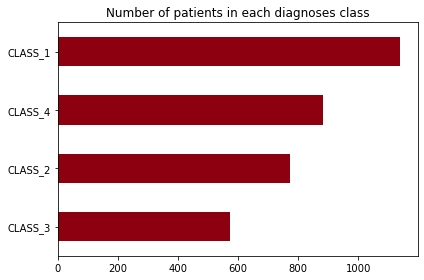

In [27]:
fig,ax = plt.subplots()
(cohort_p1_class.AE_CLASS.value_counts()[::-1]).plot(kind="barh",title="Number of patients in each diagnoses class",ax=ax, color='xkcd:crimson')
plt.tight_layout()

In [28]:
cohort_p1_class.AE_CLASS.value_counts(sort=False, ascending=False)

CLASS_1    1140
CLASS_3     574
CLASS_2     773
CLASS_4     884
Name: AE_CLASS, dtype: int64

In [29]:
cohort_p1_class.AE_CLASS.value_counts()

CLASS_1    1140
CLASS_4     884
CLASS_2     773
CLASS_3     574
Name: AE_CLASS, dtype: int64

In [30]:
cohort_p1_class

,PAT_DEID,DX_ID,DX_NAME,ICD9,ICD10,PRIMARY,CHRONIC,PRINCIPAL,CONTACT_DATE,HOSP_ADMSN_TIME,HOSP_DISCHRG_TIME,PT_CLASS,PAT_ENC_CSN_DEID,CHE_TX_DATE,SOURCE,CHE_TO_HOSP,DX_SHORT,AE_CLASS
0,1751436,1299957,"Chest pain, unspecified",None,R07.9,N,None,None,2017-05-24,2017-05-24 05:43:00,2017-05-28 11:17:00,Inpatient,131229393645,2017-05-24,<NA>,0.0,PAIN,CLASS_1
1,606517,1298657,Anemia in neoplastic disease,None,D63.0,None,None,None,2018-01-16,2018-01-16 12:35:00,2018-01-20 20:14:00,Inpatient,131242561143,2018-01-16,<NA>,0.0,ANEMIA,CLASS_3
2,1674049,1024798,Cancer associated pain,338.3,G89.3,N,N,None,2015-09-16,2015-09-16 17:49:00,2015-09-22 16:00:00,Inpatient,131114505773,2015-09-16,<NA>,0.0,PAIN,CLASS_1
4,1674049,10056,Diarrhea,787.91,R19.7,None,None,None,2015-09-16,2015-09-16 17:49:00,2015-09-22 16:00:00,Inpatient,131114505773,2015-09-16,<NA>,0.0,DIARRHEA,CLASS_2
5,788088,1298237,Hyperosmolality and hypernatremia,None,E87.0,N,None,None,2019-11-08,2019-11-08 10:57:00,2019-11-27 20:36:00,Inpatient,131277534552,2019-11-08,<NA>,0.0,DEHYDRATION,CLASS_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10887,4067,1296899,Other chest pain,None,R07.89,Y,None,None,2019-03-22,2019-03-22 23:26:00,2019-03-23 02:44:00,Emergency Services,131264058485,2019-03-21,<NA>,1.0,PAIN,CLASS_1
10894,1801062,2209778,"Non-intractable vomiting with nausea, unspecif...",787.01,R11.2,Y,N,None,2019-10-01,2019-10-01 03:45:00,2019-10-01 07:47:00,Emergency Services,131275373863,2019-09-30,<NA>,1.0,EMESIS,CLASS_2
10895,1801062,1348790,Unspecified abdominal pain,None,R10.9,None,None,None,2019-10-01,2019-10-01 03:45:00,2019-10-01 07:47:00,Emergency Services,131275373863,2019-09-30,<NA>,1.0,PAIN,CLASS_1
10899,1968696,1052706,Acute chest pain,786.50,R07.9,N,N,None,2016-10-08,2016-10-08 22:28:00,2016-10-09 01:59:00,Emergency Services,131199851544,2016-10-07,<NA>,1.0,PAIN,CLASS_1


In [31]:
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.cohort_p1_class"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = cohort_p1_class,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=7b8b2c0e-2852-40c3-8aa9-0604043a5e00>

### Build Outcome Tables

In [32]:
sql_query = f""" SELECT * FROM {es}.cohort_p1_class"""
cohort_p1_class = (client.query(sql_query)).to_dataframe()

In [33]:
cohort_p1_class.sort_values(["PAT_DEID"], inplace=True)

**- Table 1: Binary column for each class**

In [34]:
class_1 = cohort_p1_class['DX_SHORT'].apply(lambda x: any(y in x for y in ["PAIN"]))
class_2 = cohort_p1_class['DX_SHORT'].apply(lambda x: any(y in x for y in ["NAUSEA","EMESIS", "DEHYDRATION", "DIARRHEA"]))
class_3 = cohort_p1_class['DX_SHORT'].apply(lambda x: any(y in x for y in ["ANEMIA"]))
class_4 = cohort_p1_class['DX_SHORT'].apply(lambda x: any(y in x for y in ["FEVER", "NEUTROPENIA", "SEPSIS", "PNEUMONIA"]))


In [35]:
# Create a binary column for each class
cohort_p1_class.loc[class_1,"CLASS_1"] = 1 
cohort_p1_class.loc[~class_1,"CLASS_1"] = 0 

cohort_p1_class.loc[class_2,"CLASS_2"] = 1 
cohort_p1_class.loc[~class_2,"CLASS_2"] = 0 

cohort_p1_class.loc[class_3,"CLASS_3"] = 1 
cohort_p1_class.loc[~class_3,"CLASS_3"] = 0 

cohort_p1_class.loc[class_4,"CLASS_4"] = 1 
cohort_p1_class.loc[~class_4,"CLASS_4"] = 0 
cohort_p1_class

,PAT_DEID,DX_ID,DX_NAME,ICD9,ICD10,PRIMARY,CHRONIC,PRINCIPAL,CONTACT_DATE,HOSP_ADMSN_TIME,...,PAT_ENC_CSN_DEID,CHE_TX_DATE,SOURCE,CHE_TO_HOSP,DX_SHORT,AE_CLASS,CLASS_1,CLASS_2,CLASS_3,CLASS_4
308,31,2769,Anemia in neoplastic disease,285.22,D63.0,None,None,None,2014-02-18,2014-02-24 15:04:00,...,131028594371,2014-02-04 12:27:00,<NA>,20.0,ANEMIA,CLASS_3,0.0,0.0,1.0,0.0
1685,2374,1348790,Unspecified abdominal pain,None,R10.9,Y,None,None,2019-05-20,2019-05-20 19:22:00,...,131266791249,2019-05-20 00:00:00,<NA>,0.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
1398,2374,1297269,Toxic gastroenteritis and colitis,None,K52.1,None,None,None,2019-05-20,2019-05-20 19:22:00,...,131266791249,2019-05-20 00:00:00,<NA>,0.0,EMESIS,CLASS_2,0.0,1.0,0.0,0.0
2319,2374,1299691,"Fever, unspecified",None,R50.9,N,None,None,2019-05-20,2019-05-20 19:22:00,...,131266791249,2019-05-20 00:00:00,<NA>,0.0,FEVER,CLASS_4,0.0,0.0,0.0,1.0
2781,4067,1296899,Other chest pain,None,R07.89,Y,None,None,2019-03-22,2019-03-22 23:26:00,...,131264058485,2019-03-21 00:00:00,<NA>,1.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,4259783,1024798,Cancer associated pain,338.3,G89.3,N,Y,None,2021-02-02,2021-02-02 03:44:00,...,131301675918,2021-01-22 00:00:00,<NA>,11.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
2761,4316371,1296899,Other chest pain,None,R07.89,Y,None,None,2021-02-23,2021-02-23 16:07:00,...,131303173028,2021-02-23 00:00:00,<NA>,0.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
339,4316371,1298657,Anemia in neoplastic disease,None,D63.0,None,None,None,2021-02-23,2021-02-23 16:07:00,...,131303173028,2021-02-23 00:00:00,<NA>,0.0,ANEMIA,CLASS_3,0.0,0.0,1.0,0.0
3133,4317533,1297413,Jaw pain,None,R68.84,None,None,None,2021-03-31,2021-04-19 10:03:00,...,131306528290,2021-03-29 00:00:00,<NA>,21.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0


In [36]:
outcome_table_1 = cohort_p1_class.groupby('PAT_DEID', as_index=False)[["CLASS_1", "CLASS_2","CLASS_3", "CLASS_4"]].sum()

In [37]:
class_tab = []

for pat_id in pd.unique(cohort_p1_class.PAT_DEID):
    classes = cohort_p1_class[cohort_p1_class["PAT_DEID"] ==  pat_id]["AE_CLASS"].str.lower().tolist()
    class_tab.append(classes)

In [38]:
outcome_table_1["CLASSES"] = class_tab

In [39]:
# Add a column TOTAL for the number of classes per patient 
outcome_table_1["TOTAL"] = outcome_table_1.iloc[:, 1:5].sum(axis=1)
outcome_table_1

,PAT_DEID,CLASS_1,CLASS_2,CLASS_3,CLASS_4,CLASSES,TOTAL
0,31,0.0,0.0,1.0,0.0,[class_3],1.0
1,2374,1.0,1.0,0.0,1.0,"[class_1, class_2, class_4]",3.0
2,4067,1.0,0.0,0.0,0.0,[class_1],1.0
3,10540,0.0,1.0,0.0,1.0,"[class_4, class_2]",2.0
4,10789,1.0,1.0,0.0,0.0,"[class_1, class_2]",2.0
...,...,...,...,...,...,...,...
1748,4230712,1.0,1.0,0.0,1.0,"[class_1, class_4, class_2]",3.0
1749,4244010,0.0,1.0,0.0,0.0,[class_2],1.0
1750,4259783,1.0,1.0,1.0,0.0,"[class_3, class_2, class_1]",3.0
1751,4316371,1.0,0.0,1.0,0.0,"[class_1, class_3]",2.0


In [40]:
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.outcome_table_1"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = outcome_table_1,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=d51ee8b7-0cba-469b-a14a-a3bee8f9c163>

**- Table 2: Number of distinct AE column for each class**

Ex: if a patient had vomiting and nausea in Table 1 in class_2 he will have a 1.0 and in Table 2 in class_2 he will have a 2.0

In [41]:
# Define classes using cohort_p1_sym_unique (each symptom has only one occurence)
class_1_count = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["PAIN"]))
class_2_count = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["NAUSEA","EMESIS", "DEHYDRATION", "DIARRHEA"]))
class_3_count = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["ANEMIA"]))
class_4_count = cohort_p1_sym_unique['DX_SHORT'].apply(lambda x: any(y in x for y in ["FEVER", "NEUTROPENIA", "SEPSIS", "PNEUMONIA"]))


# Create a binary column for each class
cohort_p1_sym_unique.loc[class_1_count,"CLASS_1"] = 1
cohort_p1_sym_unique.loc[~class_1_count,"CLASS_1"] = 0 

cohort_p1_sym_unique.loc[class_2_count,"CLASS_2"] = 1 
cohort_p1_sym_unique.loc[~class_2_count,"CLASS_2"] = 0 

cohort_p1_sym_unique.loc[class_3_count,"CLASS_3"] = 1 
cohort_p1_sym_unique.loc[~class_3_count,"CLASS_3"] = 0 

cohort_p1_sym_unique.loc[class_4_count,"CLASS_4"] = 1 
cohort_p1_sym_unique.loc[~class_4_count,"CLASS_4"] = 0 

cohort_p1_sym_unique

<ipython-input-41-c39bd6adb2aa>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_p1_sym_unique.loc[class_1_count,"CLASS_1"] = 1
<ipython-input-41-c39bd6adb2aa>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_p1_sym_unique.loc[class_2_count,"CLASS_2"] = 1
<ipython-input-41-c39bd6adb2aa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,PAT_DEID,DX_ID,DX_NAME,ICD9,ICD10,PRIMARY,CHRONIC,PRINCIPAL,CONTACT_DATE,HOSP_ADMSN_TIME,...,PAT_ENC_CSN_DEID,CHE_TX_DATE,SOURCE,CHE_TO_HOSP,DX_SHORT,AE_CLASS,CLASS_1,CLASS_2,CLASS_3,CLASS_4
0,1751436,1299957,"Chest pain, unspecified",None,R07.9,N,None,None,2017-05-24,2017-05-24 05:43:00,...,131229393645,2017-05-24,<NA>,0.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
1,606517,1298657,Anemia in neoplastic disease,None,D63.0,None,None,None,2018-01-16,2018-01-16 12:35:00,...,131242561143,2018-01-16,<NA>,0.0,ANEMIA,CLASS_3,0.0,0.0,1.0,0.0
2,1674049,1024798,Cancer associated pain,338.3,G89.3,N,N,None,2015-09-16,2015-09-16 17:49:00,...,131114505773,2015-09-16,<NA>,0.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
4,1674049,10056,Diarrhea,787.91,R19.7,None,None,None,2015-09-16,2015-09-16 17:49:00,...,131114505773,2015-09-16,<NA>,0.0,DIARRHEA,CLASS_2,0.0,1.0,0.0,0.0
5,788088,1298237,Hyperosmolality and hypernatremia,None,E87.0,N,None,None,2019-11-08,2019-11-08 10:57:00,...,131277534552,2019-11-08,<NA>,0.0,DEHYDRATION,CLASS_2,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10887,4067,1296899,Other chest pain,None,R07.89,Y,None,None,2019-03-22,2019-03-22 23:26:00,...,131264058485,2019-03-21,<NA>,1.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
10894,1801062,2209778,"Non-intractable vomiting with nausea, unspecif...",787.01,R11.2,Y,N,None,2019-10-01,2019-10-01 03:45:00,...,131275373863,2019-09-30,<NA>,1.0,EMESIS,CLASS_2,0.0,1.0,0.0,0.0
10895,1801062,1348790,Unspecified abdominal pain,None,R10.9,None,None,None,2019-10-01,2019-10-01 03:45:00,...,131275373863,2019-09-30,<NA>,1.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0
10899,1968696,1052706,Acute chest pain,786.50,R07.9,N,N,None,2016-10-08,2016-10-08 22:28:00,...,131199851544,2016-10-07,<NA>,1.0,PAIN,CLASS_1,1.0,0.0,0.0,0.0


In [42]:
outcome_table_2 = cohort_p1_sym_unique.groupby('PAT_DEID', as_index=False)[["CLASS_1", "CLASS_2","CLASS_3", "CLASS_4"]].sum()

In [43]:
outcome_table_2

,PAT_DEID,CLASS_1,CLASS_2,CLASS_3,CLASS_4
0,31,0.0,0.0,1.0,0.0
1,2374,1.0,2.0,0.0,1.0
2,4067,1.0,0.0,0.0,0.0
3,10540,0.0,2.0,0.0,1.0
4,10789,1.0,2.0,0.0,0.0
...,...,...,...,...,...
1748,4230712,1.0,1.0,0.0,1.0
1749,4244010,0.0,1.0,0.0,0.0
1750,4259783,1.0,1.0,1.0,0.0
1751,4316371,1.0,0.0,1.0,0.0


In [44]:
# Add a column TOTAL for the number of unique AE per patient 
outcome_table_2["TOTAL"] = outcome_table_2.iloc[:, 1:5].sum(axis=1)
outcome_table_2

,PAT_DEID,CLASS_1,CLASS_2,CLASS_3,CLASS_4,TOTAL
0,31,0.0,0.0,1.0,0.0,1.0
1,2374,1.0,2.0,0.0,1.0,4.0
2,4067,1.0,0.0,0.0,0.0,1.0
3,10540,0.0,2.0,0.0,1.0,3.0
4,10789,1.0,2.0,0.0,0.0,3.0
...,...,...,...,...,...,...
1748,4230712,1.0,1.0,0.0,1.0,3.0
1749,4244010,0.0,1.0,0.0,0.0,1.0
1750,4259783,1.0,1.0,1.0,0.0,3.0
1751,4316371,1.0,0.0,1.0,0.0,2.0


In [45]:
outcome_table_2.TOTAL.value_counts()

1.0    533
2.0    524
3.0    303
4.0    204
5.0    111
6.0     61
7.0     15
8.0      2
Name: TOTAL, dtype: int64

In [46]:
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.outcome_table_2"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = outcome_table_2,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=b55bdb0e-4d6d-410a-b622-a2addeccd7e3>

**- Table 3: Frequency (# Number of AE) column for each class**

Ex: If patient had nausea, nausea, nausea, vomitting, vomitting Table 2 will had 2 in class_2 while Table 3 will have 5

In [47]:
# Define classes using cohort_p1_sym (where a patient can have several occurence of the same AE) and not cohort_p1_sym (each symptom has only one occurence)
class_1_freq = cohort_p1_sym['DX_SHORT'].apply(lambda x: any(y in x for y in ["PAIN"]))
class_2_freq = cohort_p1_sym['DX_SHORT'].apply(lambda x: any(y in x for y in ["NAUSEA","EMESIS", "DEHYDRATION", "DIARRHEA"]))
class_3_freq = cohort_p1_sym['DX_SHORT'].apply(lambda x: any(y in x for y in ["ANEMIA"]))
class_4_freq = cohort_p1_sym['DX_SHORT'].apply(lambda x: any(y in x for y in ["FEVER", "NEUTROPENIA", "SEPSIS", "PNEUMONIA"]))


# Create a binary column for each class
cohort_p1_sym.loc[class_1_freq,"CLASS_1"] = 1
cohort_p1_sym.loc[~class_1_freq,"CLASS_1"] = 0 

cohort_p1_sym.loc[class_2_freq,"CLASS_2"] = 1 
cohort_p1_sym.loc[~class_2_freq,"CLASS_2"] = 0 

cohort_p1_sym.loc[class_3_freq,"CLASS_3"] = 1 
cohort_p1_sym.loc[~class_3_freq,"CLASS_3"] = 0 

cohort_p1_sym.loc[class_4_freq,"CLASS_4"] = 1 
cohort_p1_sym.loc[~class_4_freq,"CLASS_4"] = 0 

cohort_p1_sym

,PAT_DEID,DX_ID,DX_NAME,ICD9,ICD10,PRIMARY,CHRONIC,PRINCIPAL,CONTACT_DATE,HOSP_ADMSN_TIME,...,PT_CLASS,PAT_ENC_CSN_DEID,CHE_TX_DATE,SOURCE,CHE_TO_HOSP,DX_SHORT,CLASS_1,CLASS_2,CLASS_3,CLASS_4
0,1751436,1299957,"Chest pain, unspecified",None,R07.9,N,None,None,2017-05-24,2017-05-24 05:43:00,...,Inpatient,131229393645,2017-05-24,<NA>,0.0,PAIN,1.0,0.0,0.0,0.0
1,606517,1298657,Anemia in neoplastic disease,None,D63.0,None,None,None,2018-01-16,2018-01-16 12:35:00,...,Inpatient,131242561143,2018-01-16,<NA>,0.0,ANEMIA,0.0,0.0,1.0,0.0
2,1674049,1024798,Cancer associated pain,338.3,G89.3,N,N,None,2015-09-16,2015-09-16 17:49:00,...,Inpatient,131114505773,2015-09-16,<NA>,0.0,PAIN,1.0,0.0,0.0,0.0
3,1674049,1024795,Neoplasm related pain (acute) (chronic),338.3,G89.3,None,None,None,2015-09-16,2015-09-16 17:49:00,...,Inpatient,131114505773,2015-09-16,<NA>,0.0,PAIN,1.0,0.0,0.0,0.0
4,1674049,10056,Diarrhea,787.91,R19.7,None,None,None,2015-09-16,2015-09-16 17:49:00,...,Inpatient,131114505773,2015-09-16,<NA>,0.0,DIARRHEA,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10898,1801062,1359836,"Nausea with vomiting, unspecified",None,R11.2,None,None,None,2019-10-01,2019-10-01 03:45:00,...,Emergency Services,131275373863,2019-09-30,<NA>,1.0,EMESIS,0.0,1.0,0.0,0.0
10899,1968696,1052706,Acute chest pain,786.50,R07.9,N,N,None,2016-10-08,2016-10-08 22:28:00,...,Emergency Services,131199851544,2016-10-07,<NA>,1.0,PAIN,1.0,0.0,0.0,0.0
10900,1968696,1299957,"Chest pain, unspecified",None,R07.9,N,None,None,2016-10-08,2016-10-08 22:28:00,...,Emergency Services,131199851544,2016-10-07,<NA>,1.0,PAIN,1.0,0.0,0.0,0.0
10901,1968696,1299957,"Chest pain, unspecified",None,R07.9,None,None,None,2016-10-08,2016-10-08 22:28:00,...,Emergency Services,131199851544,2016-10-07,<NA>,1.0,PAIN,1.0,0.0,0.0,0.0


In [48]:
outcome_table_3 = cohort_p1_sym.groupby('PAT_DEID', as_index=False)[["CLASS_1", "CLASS_2","CLASS_3", "CLASS_4"]].sum()

In [49]:
# Add a column TOTAL for the number of AE per patient 
outcome_table_3["TOTAL"] = outcome_table_3.iloc[:, 1:5].sum(axis=1)
outcome_table_3

,PAT_DEID,CLASS_1,CLASS_2,CLASS_3,CLASS_4,TOTAL
0,31,0.0,0.0,1.0,0.0,1.0
1,2374,1.0,2.0,0.0,2.0,5.0
2,4067,4.0,0.0,0.0,0.0,4.0
3,10540,0.0,5.0,0.0,5.0,10.0
4,10789,5.0,9.0,0.0,0.0,14.0
...,...,...,...,...,...,...
1748,4230712,1.0,6.0,0.0,3.0,10.0
1749,4244010,0.0,1.0,0.0,0.0,1.0
1750,4259783,5.0,2.0,1.0,0.0,8.0
1751,4316371,2.0,0.0,1.0,0.0,3.0


In [50]:
outcome_table_3.TOTAL.value_counts()

3.0     234
1.0     212
2.0     186
4.0     181
6.0     160
5.0     143
7.0     115
8.0      88
9.0      74
10.0     67
11.0     50
13.0     49
12.0     45
14.0     31
15.0     29
16.0     26
17.0     14
18.0     11
23.0      9
19.0      6
26.0      5
22.0      5
29.0      3
27.0      3
21.0      2
32.0      1
31.0      1
20.0      1
43.0      1
28.0      1
Name: TOTAL, dtype: int64

In [51]:
# Specify destination for storing dataframe
destination = f"som-nero-phi-boussard.ES_ACU_Oncology.outcome_table_3"

# Save file to Big Query
load_job = client.load_table_from_dataframe(dataframe = outcome_table_3,                                  
                                                   destination = destination,
                                                   job_config = job_config)

# Run the job:
load_job.result()

LoadJob<project=som-nero-phi-boussard, location=US, id=1e6f64ae-f2a8-4dcc-b276-a78b812708a6>